# Notebook 2 Outline: 02_part2_polyreg.ipynb

## Polynomial Regression - Stellar Luminosity with Nonlinear and Interaction Effects

## SetUp

In [86]:
# Install required libraries (run this once if needed)
%pip install numpy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [87]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.set_printoptions(precision=4, suppress=True)


## Dataset Definition

In [88]:
# Stellar Mass (in solar masses)
M = np.array([0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])

# Stellar Temperature (Kelvin)
T = np.array([3800, 4400, 5800, 6400, 6900, 7400, 7900, 8300, 8800, 9200])

# Stellar Luminosity (in solar luminosities)
L = np.array([0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0])

n = len(M)  # number of samples

## Dataset Visualization

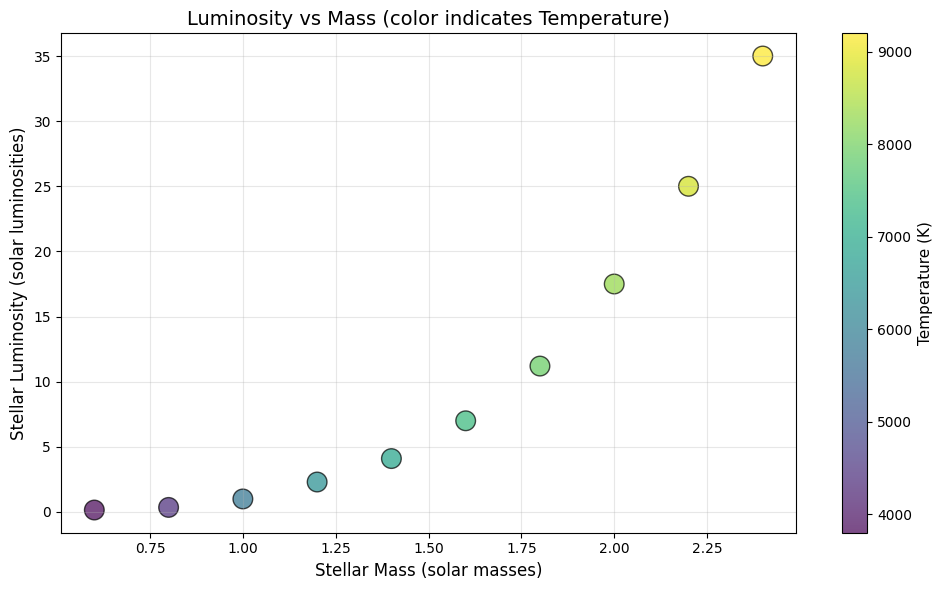

In [89]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(M, L, c=T, s=200, cmap='viridis', edgecolors='black', alpha=0.7)
plt.xlabel('Stellar Mass (solar masses)', fontsize=12)
plt.ylabel('Stellar Luminosity (solar luminosities)', fontsize=12)
plt.title('Luminosity vs Mass (color indicates Temperature)', fontsize=14)
cbar = plt.colorbar(scatter)
cbar.set_label('Temperature (K)', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 3. Feature Engineering: Creating the Design Matrix

We transformed the original features [M, T] into an enriched space:

**Feature Map**: X = [M, T, M², M·T]

This allows the model to capture:
- Linear effects of M and T
- Quadratic effects of M (M²)
- Interactions between M and T (M·T)

In [90]:
def create_polynomial_features(M, T):
    """
    Creates the design matrix with polynomial features.
    Parameters:
    M: array of stellar masses (m,)
    T: array of temperatures (m,)
    Returns:
    X: design matrix (m, 4) with columns [M, T, M², M·T]
    """
    m = len(M)
    
    # Create matrix with 4 columns
    X = np.zeros((m, 4))
    X[:, 0] = M           # Feature 1: M
    X[:, 1] = T           # Feature 2: T
    X[:, 2] = M ** 2      # Feature 3: M²
    X[:, 3] = M * T       # Feature 4: M·T (interaction)
    
    return X

# Create design matrix
X = create_polynomial_features(M, T)

print("Design Matrix X shape:", X.shape)
print("\nFirst 3 rows of X:")
print("     M        T        M²       M·T")
for i in range(3):
    print(f"{X[i,0]:6.1f}  {X[i,1]:7.0f}  {X[i,2]:6.2f}  {X[i,3]:8.0f}")

Design Matrix X shape: (10, 4)

First 3 rows of X:
     M        T        M²       M·T
   0.6     3800    0.36      2280
   0.8     4400    0.64      3520
   1.0     5800    1.00      5800


## Vectorized Implementation

### Prediction Function

$$
\hat{\vec{y}} = \mathbf{X} \vec{w} + b \,\vec{1},
$$


In [91]:
def predict(X, w, b):
    """Compute predictions f_{w,b}(x) for all examples.

    Parameters
    ----------
    X : np.ndarray, shape (m, n)
        Design matrix: each row is x^(i).
    w : np.ndarray, shape (n,)
        Parameter vector.
    b : float
        Bias term.

    Returns
    -------
    y_hat : np.ndarray, shape (m,)
        Vector of predictions for each example.
    """
    return X @ w + b  # vectorized: matrix-vector product + scalar


## Loss and Gradients (Vectorized)

**Mean Squared Error (MSE)**:
$$J(w,b) = \frac{1}{m} \sum_{i=1}^{m} \big( f_{w,b}(x^{(i)}) - y^{(i)} \big)^2$$

**Gradients**:
$$\frac{\partial J}{\partial w_j} = \frac{1}{m} \sum_{i=1}^{m} (f_{w,b}(x^{(i)}) - y^{(i)}) x_j^{(i)}, \quad
\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} (f_{w,b}(x^{(i)}) - y^{(i)})$$


In [92]:
def compute_mse(X, y, w, b):
    """Compute Mean Squared Error.
    
    Parameters
    ----------
    X : np.ndarray, shape (m, n)
    y : np.ndarray, shape (m,)
    w : np.ndarray, shape (n,)
    b : float
    
    Returns
    -------
    mse : float
    """
    m = X.shape[0]
    predictions = predict(X, w, b)
    mse = np.mean((predictions - y) ** 2)
    return mse

def compute_gradients(X, y, w, b):
    """Compute gradients of MSE w.r.t. w and b (vectorized).
    
    Parameters
    ----------
    X : np.ndarray, shape (m, n)
    y : np.ndarray, shape (m,)
    w : np.ndarray, shape (n,)
    b : float
    
    Returns
    -------
    dw : np.ndarray, shape (n,)
    db : float
    """
    m = X.shape[0]
    predictions = predict(X, w, b)
    error = predictions - y
    
    dw = (X.T @ error) / m
    db = np.mean(error)
    return dw, db

# Test
w_test = np.array([1.0, 0.001, 0.5, 0.0001])
b_test = 0.0
mse_test = compute_mse(X, L, w_test, b_test)
print(f"Test MSE: {mse_test:.4f}")


Test MSE: 64.6547


## Feature Scaling

Normalize features to mean=0, std=1 to prevent numerical overflow:
$$x_{\text{norm}} = \frac{x - \mu}{\sigma}$$


In [93]:
def normalize(X):
    """Normalize features: (x - mean) / std."""
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X - mu) / sigma
    return X_norm, mu, sigma

# Normalize all feature matrices
X_norm, mu_X, sigma_X = normalize(X)
X1_norm, mu_X1, sigma_X1 = normalize(X[:, :2])
X2_norm, mu_X2, sigma_X2 = normalize(X[:, :3])

print("Feature normalization complete")
print(f"X (full): μ={mu_X}, σ={sigma_X}")


Feature normalization complete
X (full): μ=[    1.5   6890.       2.58 11304.  ], σ=[   0.5745 1715.4883    1.7477 6371.9121]


## Gradient Descent Training

$$w := w - \alpha \frac{\partial J}{\partial w}, \quad b := b - \alpha \frac{\partial J}{\partial b}$$


In [94]:
def gradient_descent(X, y, w_init, b_init, learning_rate, iterations):
    """Gradient descent optimization.
    
    Parameters
    ----------
    X : np.ndarray, shape (m, n)
    y : np.ndarray, shape (m,)
    w_init : np.ndarray, shape (n,)
    b_init : float
    learning_rate : float
    iterations : int
    
    Returns
    -------
    w : np.ndarray, shape (n,)
    b : float
    loss_history : list
    """
    w = w_init.copy()
    b = b_init
    loss_history = []
    
    for i in range(iterations):
        # Compute gradients
        dw, db = compute_gradients(X, y, w, b)
        
        # Update parameters
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # Track loss
        if i % 20 == 0 or i == iterations - 1:
            loss = compute_mse(X, y, w, b)
            loss_history.append(loss)
            if i % 100 == 0:
                print(f"Iteration {i:4d}: MSE = {loss:.6f}")
    
    return w, b, loss_history


In [95]:
# Train Model 3 (full model: M, T, M², M*T) with NORMALIZED features
print("=" * 50)
print("TRAINING MODEL 3: [M, T, M², M*T] (NORMALIZED)")
print("=" * 50)
w3, b3, loss3 = gradient_descent(X_norm, L, np.zeros(4), 0.0, 0.01, 5000)
print(f"\nFinal MSE: {loss3[-1]:.6f}")
print(f"Learned w: {w3}")
print(f"Learned b: {b3:.6f}")


TRAINING MODEL 3: [M, T, M², M*T] (NORMALIZED)
Iteration    0: MSE = 224.702046
Iteration  100: MSE = 29.836480
Iteration  200: MSE = 16.039241
Iteration  300: MSE = 13.023201
Iteration  400: MSE = 11.580919
Iteration  500: MSE = 10.467894
Iteration  600: MSE = 9.503838


Iteration  700: MSE = 8.652593
Iteration  800: MSE = 7.898687
Iteration  900: MSE = 7.230636
Iteration 1000: MSE = 6.638567
Iteration 1100: MSE = 6.113779
Iteration 1200: MSE = 5.648568
Iteration 1300: MSE = 5.236118
Iteration 1400: MSE = 4.870389
Iteration 1500: MSE = 4.546035
Iteration 1600: MSE = 4.258321
Iteration 1700: MSE = 4.003054
Iteration 1800: MSE = 3.776520
Iteration 1900: MSE = 3.575433
Iteration 2000: MSE = 3.396881
Iteration 2100: MSE = 3.238284
Iteration 2200: MSE = 3.097362
Iteration 2300: MSE = 2.972090
Iteration 2400: MSE = 2.860681
Iteration 2500: MSE = 2.761546
Iteration 2600: MSE = 2.673284
Iteration 2700: MSE = 2.594651
Iteration 2800: MSE = 2.524546
Iteration 2900: MSE = 2.461993
Iteration 3000: MSE = 2.406131
Iteration 3100: MSE = 2.356193
Iteration 3200: MSE = 2.311504
Iteration 3300: MSE = 2.271464
Iteration 3400: MSE = 2.235542
Iteration 3500: MSE = 2.203267
Iteration 3600: MSE = 2.174225
Iteration 3700: MSE = 2.148045
Iteration 3800: MSE = 2.124402
Iteratio

## Convergence Plot: Loss vs Iterations


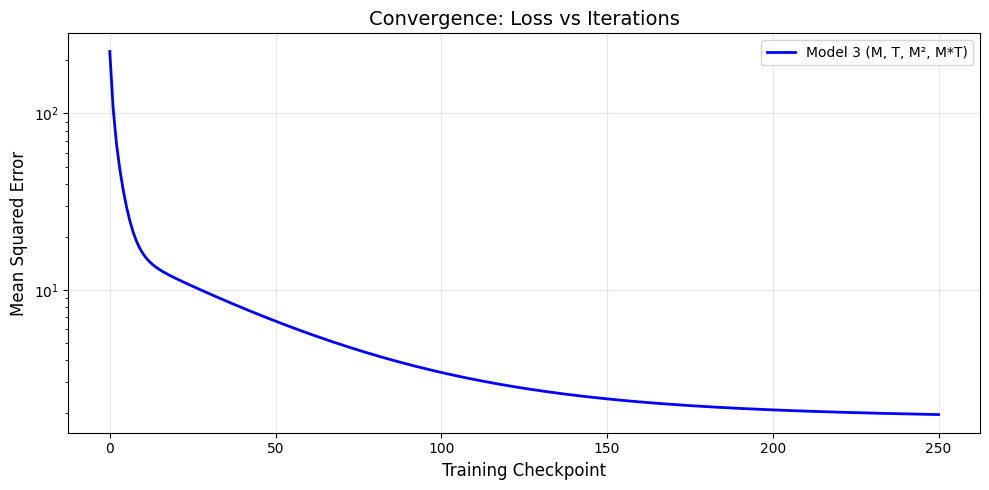

In [96]:
plt.figure(figsize=(10, 5))
plt.plot(loss3, linewidth=2, color='blue', label='Model 3 (M, T, M², M*T)')
plt.xlabel('Training Checkpoint', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.title('Convergence: Loss vs Iterations', fontsize=14)
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## Feature Selection Experiment: Compare 3 Models

**Model 1 (M1)**: X = [M, T]  
**Model 2 (M2)**: X = [M, T, M²]  
**Model 3 (M3)**: X = [M, T, M², M·T]


In [97]:
# Model 1: [M, T] with normalization
print("\n" + "=" * 50)
print("MODEL 1: X = [M, T] (NORMALIZED)")
print("=" * 50)
w1, b1, loss1_hist = gradient_descent(X1_norm, L, np.zeros(2), 0.0, 0.01, 5000)
mse1_final = loss1_hist[-1]
print(f"Final MSE: {mse1_final:.6f}")
print(f"w = {w1}")
print(f"b = {b1:.6f}")

# Model 2: [M, T, M²] with normalization
print("\n" + "=" * 50)
print("MODEL 2: X = [M, T, M²] (NORMALIZED)")
print("=" * 50)
w2, b2, loss2_hist = gradient_descent(X2_norm, L, np.zeros(3), 0.0, 0.01, 5000)
mse2_final = loss2_hist[-1]
print(f"Final MSE: {mse2_final:.6f}")
print(f"w = {w2}")
print(f"b = {b2:.6f}")

# Already trained Model 3: [M, T, M², M*T]
mse3_final = loss3[-1]

print("\n" + "=" * 50)
print("COMPARISON SUMMARY")
print("=" * 50)
print(f"Model 1 (M, T):           MSE = {mse1_final:.6f}")
print(f"Model 2 (M, T, M²):       MSE = {mse2_final:.6f}  (↓ {100*(mse1_final-mse2_final)/mse1_final:.1f}%)")
print(f"Model 3 (M, T, M², M*T):  MSE = {mse3_final:.6f}  (↓ {100*(mse1_final-mse3_final)/mse1_final:.1f}%)")



MODEL 1: X = [M, T] (NORMALIZED)
Iteration    0: MSE = 229.285600
Iteration  100: MSE = 42.288579
Iteration  200: MSE = 27.714433
Iteration  300: MSE = 25.433084
Iteration  400: MSE = 24.619107
Iteration  500: MSE = 24.014976
Iteration  600: MSE = 23.455177
Iteration  700: MSE = 22.917062
Iteration  800: MSE = 22.397079
Iteration  900: MSE = 21.894254
Iteration 1000: MSE = 21.407970
Iteration 1100: MSE = 20.937677
Iteration 1200: MSE = 20.482848
Iteration 1300: MSE = 20.042975
Iteration 1400: MSE = 19.617565
Iteration 1500: MSE = 19.206144
Iteration 1600: MSE = 18.808251
Iteration 1700: MSE = 18.423441
Iteration 1800: MSE = 18.051284
Iteration 1900: MSE = 17.691365
Iteration 2000: MSE = 17.343280
Iteration 2100: MSE = 17.006641
Iteration 2200: MSE = 16.681071
Iteration 2300: MSE = 16.366207
Iteration 2400: MSE = 16.061695
Iteration 2500: MSE = 15.767197
Iteration 2600: MSE = 15.482382
Iteration 2700: MSE = 15.206933
Iteration 2800: MSE = 14.940540
Iteration 2900: MSE = 14.682907
Itera

Iteration 4100: MSE = 12.178592
Iteration 4200: MSE = 12.011777
Iteration 4300: MSE = 11.850446
Iteration 4400: MSE = 11.694421
Iteration 4500: MSE = 11.543526
Iteration 4600: MSE = 11.397592
Iteration 4700: MSE = 11.256457
Iteration 4800: MSE = 11.119963
Iteration 4900: MSE = 10.987957
Final MSE: 10.861547
w = [18.897  -8.8063]
b = 10.360000

MODEL 2: X = [M, T, M²] (NORMALIZED)
Iteration    0: MSE = 226.922741
Iteration  100: MSE = 31.643972
Iteration  200: MSE = 17.554583
Iteration  300: MSE = 14.468889
Iteration  400: MSE = 12.954763
Iteration  500: MSE = 11.768525
Iteration  600: MSE = 10.731064
Iteration  700: MSE = 9.807159
Iteration  800: MSE = 8.982068
Iteration  900: MSE = 8.244869
Iteration 1000: MSE = 7.586104
Iteration 1100: MSE = 6.997373
Iteration 1200: MSE = 6.471177
Iteration 1300: MSE = 6.000822
Iteration 1400: MSE = 5.580332
Iteration 1500: MSE = 5.204368
Iteration 1600: MSE = 4.868166
Iteration 1700: MSE = 4.567469
Iteration 1800: MSE = 4.298477
Iteration 1900: MSE 

## Predicted vs Actual: All 3 Models


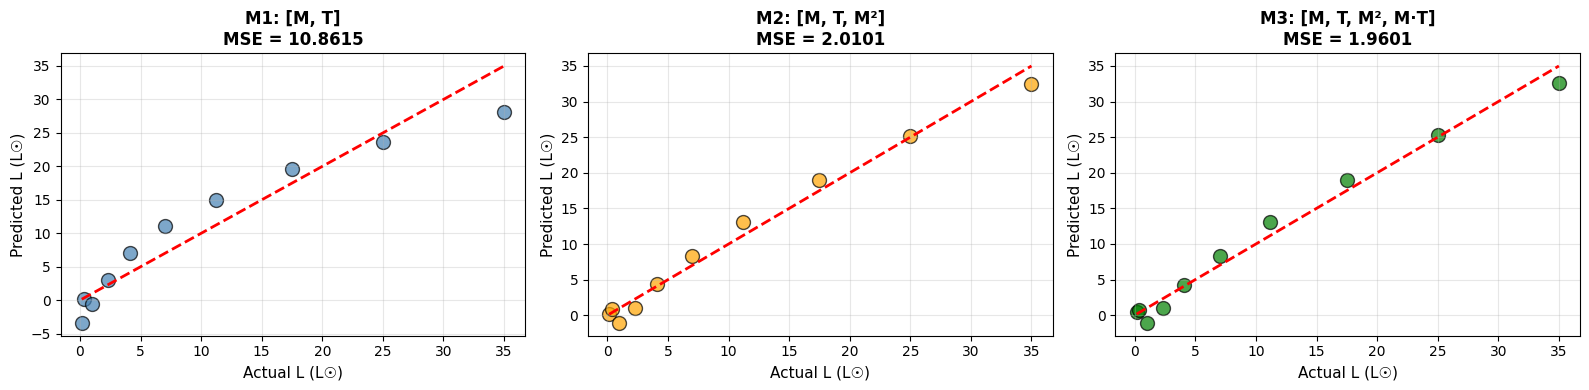

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Model 1 (normalized features)
y_pred1 = predict(X1_norm, w1, b1)
axes[0].scatter(L, y_pred1, s=100, alpha=0.7, edgecolors='black', color='steelblue')
axes[0].plot([L.min(), L.max()], [L.min(), L.max()], 'r--', linewidth=2)
axes[0].set_xlabel('Actual L ', fontsize=11)
axes[0].set_ylabel('Predicted L ', fontsize=11)
axes[0].set_title(f'M1: [M, T]\nMSE = {mse1_final:.4f}', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Model 2 (normalized features)
y_pred2 = predict(X2_norm, w2, b2)
axes[1].scatter(L, y_pred2, s=100, alpha=0.7, edgecolors='black', color='orange')
axes[1].plot([L.min(), L.max()], [L.min(), L.max()], 'r--', linewidth=2)
axes[1].set_xlabel('Actual L ', fontsize=11)
axes[1].set_ylabel('Predicted L ', fontsize=11)
axes[1].set_title(f'M2: [M, T, M²]\nMSE = {mse2_final:.4f}', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Model 3 (normalized features)
y_pred3 = predict(X_norm, w3, b3)
axes[2].scatter(L, y_pred3, s=100, alpha=0.7, edgecolors='black', color='green')
axes[2].plot([L.min(), L.max()], [L.min(), L.max()], 'r--', linewidth=2)
axes[2].set_xlabel('Actual L ', fontsize=11)
axes[2].set_ylabel('Predicted L ', fontsize=11)
axes[2].set_title(f'M3: [M, T, M², M·T]\nMSE = {mse3_final:.4f}', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Cost vs Interaction Term: Sensitivity Analysis

For Model 3, we vary the interaction coefficient $w_{MT}$ while keeping other parameters fixed at their trained values. This reveals how sensitive the model is to the M·T interaction term.


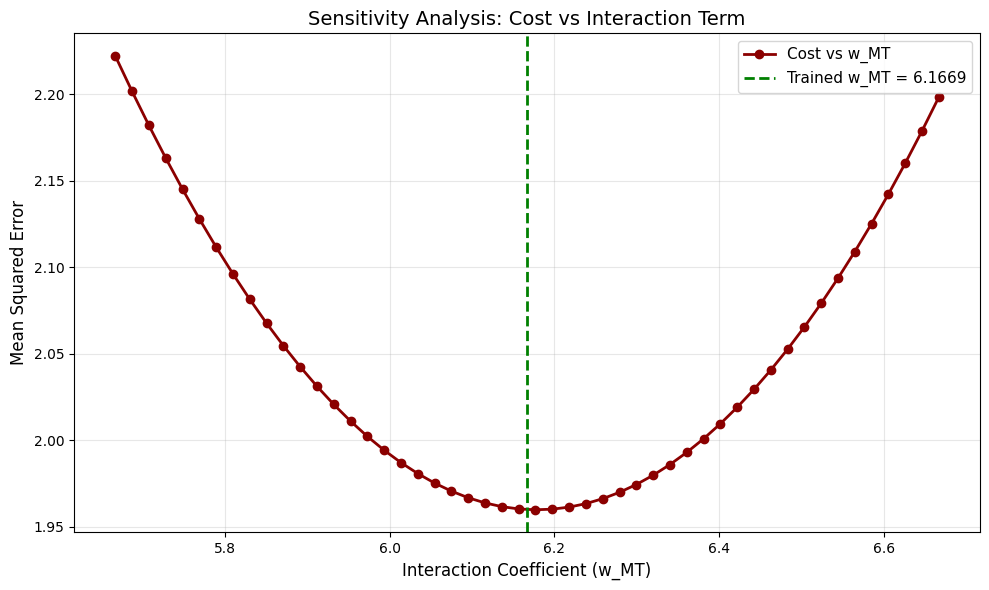


INTERACTION TERM ANALYSIS:
Trained w_MT: 6.166905
Cost range: [1.959949, 2.221964]
Sensitivity: 13.4% change in cost
Interaction term is IMPORTANT for model fit.


In [99]:
# Vary w_MT (interaction coefficient) while keeping other parameters fixed
w_MT_range = np.linspace(w3[3] - 0.5, w3[3] + 0.5, 50)
cost_vs_w_MT = []

for w_mt in w_MT_range:
    w_temp = np.array([w3[0], w3[1], w3[2], w_mt])
    cost = compute_mse(X_norm, L, w_temp, b3)
    cost_vs_w_MT.append(cost)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(w_MT_range, cost_vs_w_MT, 'o-', linewidth=2, markersize=6, color='darkred', label='Cost vs w_MT')
plt.axvline(x=w3[3], color='green', linestyle='--', linewidth=2, label=f'Trained w_MT = {w3[3]:.4f}')
plt.xlabel('Interaction Coefficient (w_MT)', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.title('Sensitivity Analysis: Cost vs Interaction Term', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

print("\nINTERACTION TERM ANALYSIS:")
print(f"Trained w_MT: {w3[3]:.6f}")
print(f"Cost range: [{min(cost_vs_w_MT):.6f}, {max(cost_vs_w_MT):.6f}]")
print(f"Sensitivity: {100*(max(cost_vs_w_MT)-min(cost_vs_w_MT))/min(cost_vs_w_MT):.1f}% change in cost")
print(f"Interaction term is {'IMPORTANT' if 100*(max(cost_vs_w_MT)-min(cost_vs_w_MT))/min(cost_vs_w_MT) > 5 else 'not critical'} for model fit.")


## Inference Demo: Predict Luminosity for a New Star

Predict the luminosity for a star with M = 1.3 solar masses and T = 6600 K.


In [101]:
# New star: M = 1.3, T = 6600
M_new = 1.3
T_new = 6600

# Create feature vector (raw)
x_new_raw = np.array([M_new, T_new, M_new**2, M_new * T_new])

# Normalize using training data statistics
x_new_norm = (x_new_raw - mu_X) / sigma_X

# Predict using Model 3 (trained on normalized features)
L_pred_new = predict(x_new_norm.reshape(1, -1), w3, b3)[0]

print(f"Input Star: M = {M_new}, T = {T_new} K")
print(f"\nRaw features: [{M_new}, {T_new}, {M_new**2:.2f}, {M_new * T_new:.0f}]")
print(f"Normalized:   [{x_new_norm[0]:.4f}, {x_new_norm[1]:.4f}, {x_new_norm[2]:.4f}, {x_new_norm[3]:.4f}]")
print(f"\nPredicted Luminosity (Model 3): {L_pred_new:.4f} ")

# Check reasonableness
print(f"\nReasonableness Check:")
print(f"  Training luminosity range: [{L.min():.2f}, {L.max():.2f}] ")
print(f"  M = {M_new} is between {M.min()} and {M.max()}")
print(f"  T = {T_new} is between {T.min()} and {T.max()}")
M_idx_close = np.argmin(np.abs(M - M_new))
print(f"  Nearby training star (M={M[M_idx_close]}): L={L[M_idx_close]:.2f} ")
print(f"  Prediction is {' REASONABLE' if L.min() <= L_pred_new <= L.max() else ' OUT OF RANGE'}")


Input Star: M = 1.3, T = 6600 K

Raw features: [1.3, 6600, 1.69, 8580]
Normalized:   [-0.3482, -0.1690, -0.5092, -0.4275]

Predicted Luminosity (Model 3): 2.7271 

Reasonableness Check:
  Training luminosity range: [0.15, 35.00] 
  M = 1.3 is between 0.6 and 2.4
  T = 6600 is between 3800 and 9200
  Nearby training star (M=1.4): L=4.10 
  Prediction is  REASONABLE
